In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Agent

In [2]:
class Agent(object):
    def __init__(self, epsilon=0.01):
        self.alpha = 0.3
        self.gamma = 1.0
        self.epsilon = epsilon
        self.gravity = 0.0025
        self.force = 0.001
        self.max_speed = 0.07
        self.min_position = -1.2
        self.max_position = 0.6
        
        self.states = self.InitializeState()
        self.actions = self.InitializeAction()
        self.numberAction = self.actions.shape[0]
        self.numberState = self.states.shape[0]
        self.q_table = self.InitializeQtable()
    
    #initialize state
    def InitializeState(self):
        states = []
        pos = np.arange(-1.2, 0.6, 0.1) #position: min: -1.2 / max: 0.6
        velocity = np.arange(-0.07, 0.07, 0.01) #velocity: min: -0.07 / max: 0.07
        
        for i in range(len(pos)):    
            for j in range(len(velocity)):
                states.append([pos[i], velocity[j]]) 
    
        return np.array(states)
    
    #initialize action
    def InitializeAction(self):
        return np.array([-1.0 , 0.0 , 1.0]) #push left, no push, right
   
    #initialize q-table
    def InitializeQtable(self):
        qTable = [[0.0 for i in range(self.numberAction)] for i in range(self.numberState)]
        return qTable
    
    #Get action
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            #return random action
            action = np.random.choice(3,1)
            action = action[0]
        else:
            #return action by q-function
            action = np.argmax(self.q_table[state]) 
        return action
    
    #Move the car 
    def move(self, actionValue, x ):
        position, velocity = x[0], x[1]
        
        velocity += actionValue*self.force + math.cos(3*position)*(-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if (position==self.min_position and velocity<0): velocity = 0
        
        next_state = np.array([position,velocity])
        
        return next_state
    
    #reward
    def get_reward(self, x ):
        position = x[0]
        goal  = 0.5
        r = -1
        stop = False
        
        if  position >= goal:
            r = 0
            stop = True
        
        return r,stop
    
    #update q_table
    def learn(self, state_index, action_index, reward, next_state_index, next_action_index):
        self.q_table[state_index][action_index]  = self.q_table[state_index][action_index] + self.alpha * (reward + self.gamma*self.q_table[next_state_index][next_action_index] - self.q_table[state_index][action_index] )
    
    def do_episode(self, maxsteps=200, grafic = False):
        state = np.array([-0.5,0.0]) # start position, velocity
        state_move = []
        cost_move=[]
        state_move.append(state)
        
        steps            = 0
        total_reward     = 0

        state_index   = np.argmin(np.sqrt(np.sum((self.states-state)**2,1)))
        
        action_index   = self.get_action(state_index)
        cost = -np.max(self.q_table[state_index])
        cost_move.append(cost)

        for i in range(1,maxsteps+1):
            action = self.actions[action_index]    
            next_state= self.move(action, state)  
            
            reward,stop = self.get_reward(next_state)
            total_reward = total_reward + reward
            
            next_state_index = np.argmin(np.sqrt(np.sum((self.states-next_state)**2,1)))
            next_action_index = self.get_action(next_state_index)
            
            self.learn(state_index,action_index,reward,next_state_index,next_action_index)
            
            cost = -np.max(self.q_table[next_state_index])
            cost_move.append(cost)
            state_move.append(next_state)
            
            state_index = next_state_index
            action_index = next_action_index
            state = next_state
            
            if grafic:
                self.PlotFunc(x,a,steps)
                
            
            steps = steps+1
            
            if stop==True:
                break
        
        return total_reward, steps, state_move, cost_move

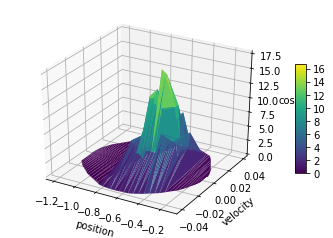

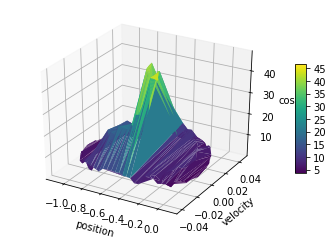

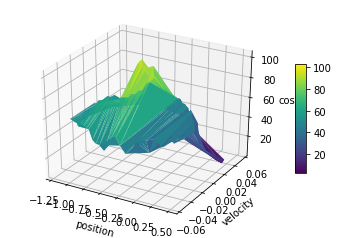

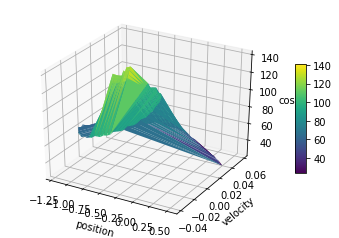

In [3]:
if __name__ == '__main__':
    sarsaAgent  = Agent()
    maxsteps = 200
    maxepisodes = 9000
    
    for i in range(1, maxepisodes+1):    
        position, velocity =[], []
        total_reward, steps, state_move, cost_move = sarsaAgent.do_episode(maxsteps)    
        for j in range(len(state_move)):
            position.append(state_move[j][0]) 
            velocity.append(state_move[j][1]) 
        
        if i==12 or i == 104 or i==1000 or i ==9000:
            fig = plt.figure()
            ax = fig.gca(projection='3d')          
            surf = ax.plot_trisurf(position, velocity, cost_move, cmap=plt.cm.viridis, linewidth=0.2)
            fig.colorbar( surf, shrink=0.5, aspect=10)
            ax.set_xlabel("position")
            ax.set_ylabel("velocity")
            ax.set_zlabel("cost")
            plt.show()
        
        sarsaAgent.epsilon = sarsaAgent.epsilon * 0.99